# Data Acquisition

from time import sleep
from bs4 import BeautifulSoup
import time
import requests
import json
import unicodedata

In [1]:
#import the libraries needed for web scraping
from time import sleep
from bs4 import BeautifulSoup
import time
import requests
import json
import unicodedata

### Using the BeautifulSuop scarper api to scrape the data from wine.com, we will scrape the landing page and iterate through the win varieties and scrape results page and product page an placing it into a dictionary for futher analysis 

In [ ]:
#Creating the scraper 
class Scraper:
#initializing the web scaper for extracting data from wine.com
    def __init__(self, pullQuantity = 10000):
        self.session = requests.Session()
        self.startTime = time.time()
        self.pullQuantity = pullQuantity
        self.staticURL = 'https://www.wine.com'
        self.siteMapDirectory = '../../data/wine-com/'
        self.filePath = '../../data/wine-com/raw/{}.txt'.format(self.startTime)
        self.headerData = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'}

       #determine if sitemap exists, initialize if not
        try:
            with open(self.siteMapDirectory + '/site-map.json', 'r') as fileObj:
                self.siteMap = json.load(fileObj)
        except:
            self.siteMap = {}
        
        #generate session file - validated
        with open(self.filePath,'w') as fileObj:
            fileObj.write('product_url|product_name|product_variety|product_origin|product_family|user_avg_rating|user_rating_count|product_description|product_reviews\n')  
        fileObj.close()
            
    def scrape(self):
        #determine landing page map exists
        if len(self.siteMap) == 0:
            self.scrapeLandingPage()
            self.parseLandingPage()
        #iterate through wine varieties
        sleep(2)
        for key, value in self.siteMap['landingPageLinks'].items():
            self.searchVarietal = key
            self.searchURL = value
            self.scrapeParseResultsPage()
            #write sitemap to JSON file
            with open(self.siteMapDirectory + '/site-map.json', 'w') as fileObj:
                json.dump(self.siteMap, fileObj)
            fileObj.close()

    # validated
    def scrapeLandingPage(self):
        landingPageResponse = self.session.get(self.staticURL, headers = self.headerData)
        self.landingPageSoup = BeautifulSoup(landingPageResponse.content, "html.parser")
    
    #validated
    def parseLandingPage(self):
        self.siteMap['landingPageLinks'] = dict()
        landingPageVarietalsLevel0 = self.landingPageSoup.find('section', attrs = {'class': 'mainNav_section mainNav_section-varietal mainNavList_item-level0'})
        for row in landingPageVarietalsLevel0.find_all('li', attrs = {'class': 'mainNavList_item mainNavList_item-level2'}):
            a_tag = row.find('a', attrs = {'class': 'mainNavList_itemLink'})
            self.varietalName = a_tag.text
            self.varietalLink = a_tag.get('href')
            self.siteMap['landingPageLinks'][self.varietalName] = self.staticURL + self.varietalLink
        #for some reason boxed sets and glassware links are present in varietals tab
        del self.siteMap['landingPageLinks']['Wine Tasting Sets']
        del self.siteMap['landingPageLinks']['Glassware & Accessories']
    
    def scrapeParseResultsPage(self):
        if self.searchVarietal not in self.siteMap:
            self.siteMap[self.searchVarietal] = dict()
        
        self.pullCount = 0
        while self.pullCount < self.pullQuantity and self.searchURL is not None:
            print(self.searchURL)
            resultsPageResponse = self.session.get(self.searchURL, headers = self.headerData)
            self.resultsPageSoup = BeautifulSoup(resultsPageResponse.content, "html.parser")
            resultsContainer = self.resultsPageSoup.find('ul', attrs = {'class':'listGridLayout_list'})
            for row in resultsContainer.find_all('div', attrs = {'class': 'listGridItemInfo'}):
                productShortLink = row.a['href']
                self.productURL = self.staticURL + productShortLink
                if self.productURL not in self.siteMap[self.searchVarietal]:
                    self.scrapeProductPage()
                    self.parseProductPage()
                else:
                    pass
            if self.pullCount < self.pullQuantity:
                try:
                    paginationContainer = self.resultsPageSoup.find('div', attrs = {'class':'nextPagePagination'})
                    self.searchURL = paginationContainer.a['href']
                except Exception:
                    self.searchURL = None
            
    #validated
    def scrapeProductPage(self):
        if self.productURL not in self.siteMap[self.searchVarietal]:
            self.siteMap[self.searchVarietal][self.productURL] = dict()
        
        try:
            productPageResponse = self.session.get(self.productURL, headers = self.headerData)
            self.productPageSoup = BeautifulSoup(productPageResponse.content, "html.parser")
            
            self.siteMap[self.searchVarietal][self.productURL]['scrapeStatus'] = 'success'
        except Exception:
            self.siteMap[self.searchVarietal][self.productURL]['scrapeStatus'] = 'fail'
            
    #validated
    def parseProductPage(self):
        try:
            #generate dictionary for parsed fields
            self.prodData = dict()
            
            #product info
            prodInfo = self.productPageSoup.find('div', attrs = {'class':'pipInfo'})
            self.prodData['Product_Name'] = prodInfo.find('h1', attrs = {'class':'pipName'}).text
            self.prodData['Product_Variety'] = prodInfo.find('span', attrs = {'class':'prodItemInfo_varietal'}).text
            self.prodData['Product_Origin'] = prodInfo.find('span', attrs = {'class':'prodItemInfo_originText'}).text
            
            #product attributes
            self.prodData['Product_Family'] = self.searchVarietal
            
            try:
                #average user product ratings
                self.prodData['User_Avg_Rating'] = self.productPageSoup.find('span', attrs = {'class':'averageRating_average'}).text
            except Exception:
                self.prodData['User_Avg_Rating'] = 'nan'
                
            try:
                #product ratings count
                self.prodData['User_Rating_Count'] = self.productPageSoup.find('span', attrs = {'class':'averageRating_number'}).text
            except Exception:
                self.prodData['User_Rating_Count'] = 'nan'
                
            try:
                #winemaker notes
                prodNotes = self.productPageSoup.find('div', attrs = {'class':'pipWineNotes_copy viewMoreModule js-expanded'})
                wineMakerNotes = prodNotes.find('div', attrs = {'class': 'viewMoreModule_text'}).text
                wineMakerNotes = wineMakerNotes.replace('\n', ' ')
                wineMakerNotes = unicodedata.normalize('NFKD', wineMakerNotes)
                self.prodData['Winemaker_Description'] = wineMakerNotes
            except Exception:
                self.prodData['Winemaker_Description'] = 'nan'
            
            try:
                #professional reviews
                prodProfessionalReviews = self.productPageSoup.find('div', attrs = {'class': 'viewMoreModule_text viewMoreModule-reviews'})
                self.prodData['Critical_Reviews'] = []
                for row in prodProfessionalReviews.find_all('div', attrs = {'class': 'pipProfessionalReviews_list'}):
                    reviewer_name = row.find('div', attrs = {'class': 'pipProfessionalReviews_authorName'}).text
                    reviewer_rating = row.find('span', attrs = {'class': 'wineRatings_rating'}).text
                    reviewer_text = row.find('div', attrs = {'class': 'pipSecContent_copy'}).text
                    reviewer_text = reviewer_text.replace('\n', ' ')
                    reviewer_text = unicodedata.normalize('NFKD', reviewer_text)                             
                    self.prodData['Critical_Reviews'].append(f'({reviewer_name}; {reviewer_rating}; {reviewer_text})')
            except Exception:
                print('review parse failed')
                self.prodData['Critical_Reviews'] = 'nan'

            #write data to disk
            self.writeProductData()
            self.siteMap[self.searchVarietal][self.productURL]['parseStatus'] = 'success'
        except Exception:
            self.siteMap[self.searchVarietal][self.productURL]['parseStatus'] = 'fail'
            print('{} parse failed'.format(self.productURL))

    #validated
    def writeProductData(self):
        try:
            with open(self.filePath, 'a') as file:
                file.write('{}|{}|{}|{}|{}|{}|{}|{}|{}\n'.format(self.productURL,
                                                                 self.prodData['Product_Name'],
                                                                 self.prodData['Product_Variety'],
                                                                 self.prodData['Product_Origin'],
                                                                 self.prodData['Product_Family'],
                                                                 self.prodData['User_Avg_Rating'],
                                                                 self.prodData['User_Rating_Count'],
                                                                 self.prodData['Winemaker_Description'],
                                                                 self.prodData['Critical_Reviews']))
            file.close()
            self.pullCount += 1
            self.siteMap[self.searchVarietal][self.productURL]['writeStatus'] = 'success'
        except Exception:
            self.siteMap[self.searchVarietal][self.productURL]['writeStatus'] = 'fail'


In [ ]:
wine_com_scraper = Scraper()
wine_com_scraper.scrape()

# Preprocessing - Wine.com

### Summary
The code contained within this file aims to reconcile and process data scraped from Wine.com.

This implementation observes the following considerations:
1. Given that scrapes can and will fail, this script assumes that all files present in the raw folder are to be processed and combined into a master record. Redundant records and processing are prevented through the use of a site map that tracks successfully parsed and written pages.
2. Ideally, this data would best be stored in a database with a mininum of two tables, product info and critical reviews, however as this analysis is predominantly interested in review data, a SQL style left join has been deemed adequate for this analysis despite the effect on the overall file size. This is a case of not letting perfect get in the way of good enough or having an "agile" mindset.
3. The preprocess_text.py file contains the preprocess_text Class to be used in pipeline when addressing novel data.

In [9]:
#imports
import numpy as np
import pandas as pd
import os
import re
import string
import time
from sklearn.base import TransformerMixin
from nltk.corpus import stopwords

In [2]:
#set directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
raw_folder = parent_directory + '/data/wine-com/raw/'
processed_folder = parent_directory + '/data/wine-com/processed/'

### Load Data

In [5]:
#instantiate data structure to hold initial raw data/critical critical reviews
data = dict()
review_data = dict()
#iterate through wine.com raw data folder
for filename in os.listdir(raw_folder):
    #determine if file has already been processed - if true pass
    if filename not in os.listdir(processed_folder):
        print(f'{filename} loading')
        data[filename] = dict()
        review_data[filename] = dict()
        #open file readlines to raw dictionary
        with open(raw_folder + filename, newline='\r\n') as file:
            header = next(file)
            data[filename]['lines'] = file.readlines()
        #create list to hold parsed records
        data[filename]['data'] = []
        review_data[filename]['data'] = []
        #iterate through records to parse raw data
        for line in data[filename]['lines']:
            values = line.strip().split('|')
            #while redundancy is built into the scraper to ensure that the correct format is achieved,
            #this prevents rogue html from causing a bad data load
            if len(values) == 9:
                row = {
                    'product_url': values[0],
                    'product_name': values[1],
                    'product_variety': values[2],
                    'product_origin': values[3],
                    'product_family': values[4],
                    'user_avg_rating': values[5],
                    'user_rating_count': values[6],
                    'winemaker_description': values[7]
                    #'critical_reviews' is parsed loaded below
                }
                #write to list to be loaded to dataframe
                data[filename]['data'].append(row)
                
                #parse critical reviews - should be loaded as list
                reviews = values[8].split(';')
                for review in reviews:
                    try:
                        reviewer_name, reviewer_rating, reviewer_text = review.split(',')
                        review = {
                        'product_url': values[0],
                        'reviewer_name': reviewer_name,
                        'reviewer_rating': reviewer_rating,
                        'reviewer_text': reviewer_text
                        }
                        
                        review_data[filename]['data'].append(review)
                    except Exception:
                        pass      
                    
        # Convert the list of dictionaries to a Pandas DataFrame
        data[filename]['unmerged_df'] = pd.DataFrame(data[filename]['data'])
        review_data[filename]['df'] = pd.DataFrame(review_data[filename]['data'])
        
        #perform sql-style left join of review data onto main df
        data[filename]['merged_df'] = pd.merge(data[filename]['unmerged_df'], 
                                               review_data[filename]['df'], 
                                               on='product_url', 
                                               how='left')

1677386048.5362737.txt loading
1677417882.7459548.txt loading


We created two .txt file one for raw data and another for ciritcal review  

### Data Preprocessing

Using the transformerMixin to preprocess text data by removing stopwords, punctuation, and converting text to lowercase.

In [19]:
# a text preprocessor class is created to manage preprocessing of text fields
# inheriting from TransformerMixin of Sklearn, this should allow for tying into large sklearn pipeline
class preprocess_text(TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            #standardize type
            X = X.astype(str)
            # lower text
            X = X.str.lower()
            # remove punctuation
            X = X.str.replace('\W+', ' ', regex = True)
            # tokenize text into individual words
            X = X.str.split()
            # remove stopwords
            X = X.apply(lambda x: [word for word in x if word not in (self.stop_words)])
            # join words
            X = X.apply(lambda x: ' '.join(x))
            return X
        elif isinstance(X, pd.DataFrame):
            colnames = X.columns
            for col in colnames:
                #standardize type
                X[col] = X[col].astype(str)
                # convert text to lowercase
                X[col] = X[col].str.lower()
                # remove punctuation
                X[col] = X[col].str.replace('\W+', ' ', regex = True)
                # tokenize text into individual words
                X[col] = X[col].str.split()
                # remove stopwords
                X[col] = X[col].apply(lambda x: [word for word in x if word not in (self.stop_words)])
                # join words
                X[col] = X[col].apply(lambda x: ' '.join(x))
            return X
        else:
            return X
    
    def fit(self, X, y=None):
        return self

### Clean & Write Data

applying the processor to the winemaker_description and reviewer_text and saving it to a .txt 

In [20]:
processor = preprocess_text()

output_path = processed_folder + f'{time.time()}.txt'

for filename in data:
    data[filename]['merged_df']['winemaker_description'] = processor.transform(data[filename]['merged_df']['winemaker_description'])
    data[filename]['merged_df']['reviewer_text'] = processor.transform(data[filename]['merged_df']['reviewer_text'])
    data[filename]['merged_df'].to_csv(output_path,
                                       mode='a',
                                       header = not os.path.exists(output_path),
                                       sep = '|',
                                       line_terminator = '\r\n',
                                       index=False)

# Descriptive Statistics

In [1]:
#imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict

In [2]:
#directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
processed_folder = parent_directory + '/data/wine-com/processed/'

### Load Data

In [3]:
#Loading the data with pandas CSV with vertical bar separator "|"
df = pd.read_csv(processed_folder + '1677432096.083379.txt', sep = '|')

In [4]:
#Inspecting the data using .head() 
df.head()

,product_url,product_name,product_variety,product_origin,product_family,user_avg_rating,user_rating_count,winemaker_description,reviewer_name,reviewer_rating,reviewer_text
0,https://www.wine.com/product/proyecto-salvaje-...,Proyecto Salvaje del Moncayo Garnacha 2020,Grenache,"from Navarra, Spain",Red Wine,4.8,19,bright burgundy wine medium depth tobacco wild...,Decanter,92.0,part proyecto garnachas de españa collection s...
1,https://www.wine.com/product/proyecto-salvaje-...,Proyecto Salvaje del Moncayo Garnacha 2020,Grenache,"from Navarra, Spain",Red Wine,4.8,19,bright burgundy wine medium depth tobacco wild...,Wilfred Wong of Wine.com,91.0,commentary 2020 proyecto garnachas salvaje del...
2,https://www.wine.com/product/domaine-du-terme-...,Domaine du Terme Gigondas 2019,Rhone Red Blends,"from Gigondas, Rhone, France",Red Wine,4.0,17,NaN,Wine & Spirits,96.0,spectacular gigondas wine red cherry flavors s...
3,https://www.wine.com/product/domaine-du-terme-...,Domaine du Terme Gigondas 2019,Rhone Red Blends,"from Gigondas, Rhone, France",Red Wine,4.0,17,NaN,Decanter,94.0,straight first sniff clear going special soari...
4,https://www.wine.com/product/scott-harvey-moun...,Scott Harvey Mountain Selection Zinfandel 2019,Zinfandel,"from Amador, Sierra Foothills, California",Red Wine,4.3,39,fruit forward rich full flavors expressing var...,Wine Enthusiast,93.0,fresh smelling full bodied flavor packed wine ...


In [5]:
# using the .info() to get a summary of the dataframe object 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20988 entries, 0 to 20987
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_url            20988 non-null  object 
 1   product_name           20988 non-null  object 
 2   product_variety        20988 non-null  object 
 3   product_origin         20986 non-null  object 
 4   product_family         20988 non-null  object 
 5   user_avg_rating        20988 non-null  float64
 6   user_rating_count      20988 non-null  int64  
 7   winemaker_description  19337 non-null  object 
 8   reviewer_name          14537 non-null  object 
 9   reviewer_rating        14537 non-null  float64
 10  reviewer_text          14494 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.8+ MB


To aid descriptive analysis, two subsets of this dataframe will be created based on unique winemaker descriptions and unique critical reviews.

In [8]:
#Creating a new dataframe that has only one copie of product_name 
description_df = df[['product_name', 
description_df = df[['product_name', 
                     'product_family', 
                     'user_avg_rating', 
                     'user_rating_count', 
                     'winemaker_description']].drop_duplicates(subset = ['product_name'])

In [9]:
# Creating a new dataframe that only has rewiew data 
review_df = df[['product_name', 
                'product_family', 
                'reviewer_name', 
                'reviewer_rating', 
                'reviewer_text']]

### Basic Descriptive Statistics

In [10]:
df.nunique()

product_url              13672
product_name             13672
product_variety            134
product_origin             441
product_family               5
user_avg_rating             35
user_rating_count          270
winemaker_description    12258
reviewer_name               16
reviewer_rating             13
reviewer_text            14070
dtype: int64

Of note, this dataset contains 13, 672 unique products across 134 vartietals and 5 distinct wine types. On a posotive note for this analysis, descriptions provided by wine makers do not outnumber the quantity of professional reviews.

To ensure that sufficient coverage is present across wine types, the above statistics will be recomputed for each unique wine type.

In [11]:
description_df.groupby('product_family').describe()

user_avg_rating                                     \
                                  count      mean       std  min  25%  50%   
product_family                                                               
Champagne & Sparkling            1067.0  2.192690  2.038399  0.0  0.0  3.5   
Dessert, Sherry, & Port           405.0  2.373827  2.071400  0.0  0.0  3.6   
Red Wine                         7752.0  1.192363  1.869361  0.0  0.0  0.0   
Rosé Wine                         415.0  1.305301  1.929887  0.0  0.0  0.0   
White Wine                       4033.0  1.096157  1.817765  0.0  0.0  0.0   

                                  user_rating_count                         \
                         75%  max             count       mean         std   
product_family                                                               
Champagne & Sparkling    4.1  5.0            1067.0  49.145267  135.037534   
Dessert, Sherry, & Port  4.2  5.0             405.0  32.758025   73.199245   
Red Wine                 3.6  5.0            7752.0   7.779799   35.387293   
Rosé Wine                3.8  5.0             415.0  10.344578   42.256856   
White Wine               3.4  5.0            4033.0   5.987354   28.261211   

                                                      
                         min  25%  50%   75%     max  
product_family                                        
Champagne & Sparkling    0.0  0.0  7.0  40.5  1884.0  
Dessert, Sherry, & Port  0.0  0.0  9.0  31.0   619.0  
Red Wine                 0.0  0.0  0.0   6.0  1849.0  
Rosé Wine                0.0  0.0  0.0   7.0   645.0  
White Wine               0.0  0.0  0.0   5.0  1013.0

In [12]:
review_df.groupby('product_family').describe()

reviewer_rating                                   \
                                  count       mean       std   min   25%   
product_family                                                             
Champagne & Sparkling            1553.0  92.007083  2.080983  88.0  90.0   
Dessert, Sherry, & Port           687.0  93.126638  2.376385  89.0  91.0   
Red Wine                         9205.0  92.913525  2.278310  88.0  91.0   
Rosé Wine                         237.0  91.075949  1.549512  88.0  90.0   
White Wine                       2855.0  92.177933  2.038660  88.0  91.0   

                                            
                          50%   75%    max  
product_family                              
Champagne & Sparkling    92.0  93.0  100.0  
Dessert, Sherry, & Port  93.0  95.0   99.0  
Red Wine                 93.0  94.0  100.0  
Rosé Wine                91.0  92.0   97.0  
White Wine               92.0  93.0  100.0

Looking at the product counts for each data frame indicate that there is some significant imbalance present in wines available for purchase and that the range of ratings values between user and critic reviews vary significantly.

Another aspect worth noting is that unless the text bodies of 'description' and 'review' are proven to diverge significantly, predictive models would likely benefit from combining these fields into a single corpus.

### 'Description' Analysis

In [13]:
#lifted from homwork
def descriptive_stats(tokens, num_tokens = 10, verbose=True):
    tokens_str = tokens.astype(str)
    joined_series_tokens = ' '.join(tokens_str)
    tokens = joined_series_tokens.split()
    
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens #defined as unique tokens to the total number of words
    num_characters = sum(len(i) for i in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # find five most common tokens
        counter = Counter(tokens)
        n_most_common_tokens = counter.most_common(10)
        print(f"The {num_tokens} most common tokens were:\n{n_most_common_tokens}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [14]:
unique_wines = description_df['product_family'].unique()

for wine_types in unique_wines:
    tmp = description_df[description_df['product_family'] == wine_types]
    print(f'{wine_types} Outputs\n')
    descriptive_stats(tmp['winemaker_description'])
    print('\n')

Red Wine Outputs

There are 255855 tokens in the data.
There are 13949 unique tokens in the data.
There are 1550509 characters in the data.
The lexical diversity is 0.055 in the data.
The 255855 most common tokens were:
[('wine', 5058), ('red', 4884), ('fruit', 3426), ('tannins', 2993), ('notes', 2908), ('palate', 2904), ('aromas', 2824), ('black', 2652), ('finish', 2518), ('cherry', 2226)]


White Wine Outputs

There are 130342 tokens in the data.
There are 10225 unique tokens in the data.
There are 808703 characters in the data.
The lexical diversity is 0.078 in the data.
The 130342 most common tokens were:
[('wine', 2658), ('fruit', 1596), ('palate', 1590), ('white', 1520), ('aromas', 1477), ('notes', 1471), ('fresh', 1461), ('finish', 1284), ('acidity', 1213), ('citrus', 1195)]


Champagne & Sparkling Outputs

There are 46992 tokens in the data.
There are 5724 unique tokens in the data.
There are 291806 characters in the data.
The lexical diversity is 0.122 in the data.
The 46992 m

The analysis shows that the most common tokens vary depending on the type of wine. the red wine has the most tokens related to wine characteristics like fruit, tannins, and aromas.White wines have fewer tokens, and common tokens relate to fruit, palate, and acidity.Champagne & sparkling wines have higher lexical diversity, with common tokens related to freshness, notes, and fine.Rosé wines have the highest lexical diversity, with common tokens related to rosé color, freshness, and aromas.Dessert, sherry, and port wines have a similar lexical diversity to rosé wines, with common tokens related to wine characteristics like fruit, color, and richness.

### 'Review' Analysis

In [19]:
unique_wines = review_df['product_family'].unique()

for wine_types in unique_wines:
    tmp = review_df[review_df['product_family'] == wine_types]
    print(f'{wine_types} Outputs\n')
    descriptive_stats(tmp['reviewer_text'])
    print('\n')

Red Wine Outputs

There are 337417 tokens in the data.
There are 13358 unique tokens in the data.
There are 1982860 characters in the data.
The lexical diversity is 0.040 in the data.
The 337417 most common tokens were:
[('tannins', 4972), ('fruit', 4119), ('wine', 4114), ('finish', 3565), ('black', 3483), ('nan', 3420), ('bodied', 3326), ('red', 3175), ('full', 3016), ('palate', 2957)]


White Wine Outputs

There are 94927 tokens in the data.
There are 7744 unique tokens in the data.
There are 560822 characters in the data.
The lexical diversity is 0.082 in the data.
The 94927 most common tokens were:
[('nan', 2280), ('finish', 1270), ('white', 1110), ('wine', 1057), ('palate', 1037), ('fruit', 1025), ('flavors', 956), ('aromas', 953), ('notes', 908), ('acidity', 814)]


Champagne & Sparkling Outputs

There are 52945 tokens in the data.
There are 5095 unique tokens in the data.
There are 312677 characters in the data.
The lexical diversity is 0.096 in the data.
The 52945 most common t

The number of token varies across the different types of wine, with red wines having the highest number of tokens and rose wine having the hifhest lexical diversity. The great thing is that the most common tokens vary across the different types of wine will with the classificatiion model for like navie bayes model 

Based on the top 10 most common terms, joining the fields 'description' and 'reviews' may be a reasonable proposal but a transform such as TF-IDF is likely in order for this dataset as the terms themselves are largely generic.

### Description Lengths

In [21]:
description_df['description_length'] = description_df['winemaker_description'].str.len()

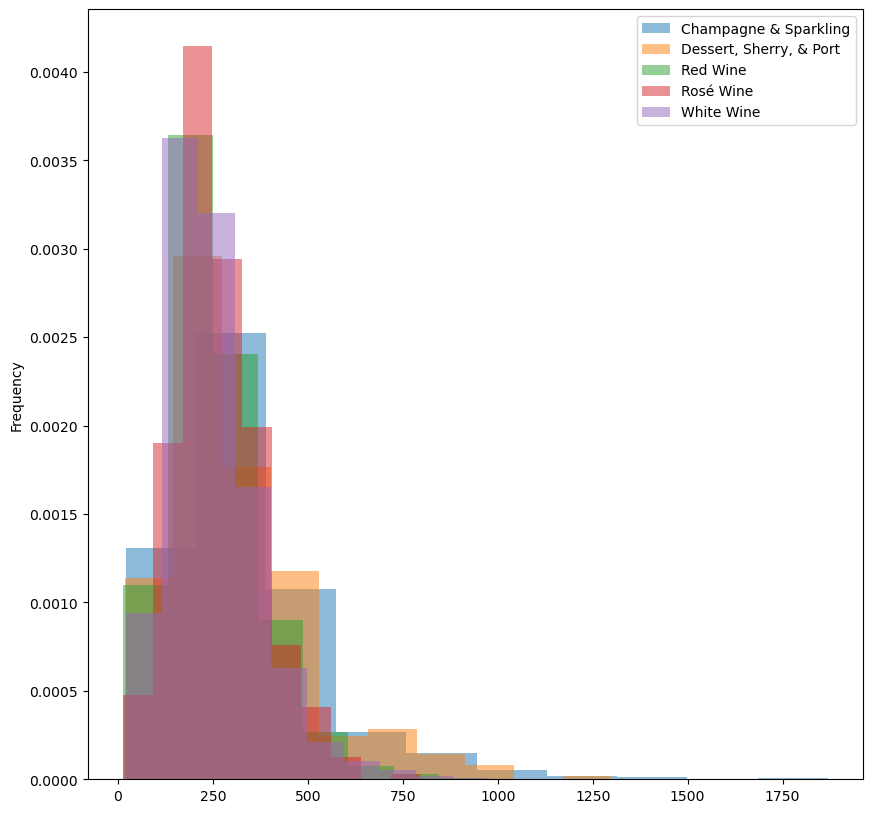

In [24]:
fig = plt.figure(figsize=(10, 10))
description_df.groupby('product_family')['description_length'].plot(kind="hist",density=True,alpha=0.5,legend=True)
plt.show()

### Review Lengths

In [25]:
review_df['review_length'] = review_df['reviewer_text'].str.len()

C:\Users\garyb\AppData\Local\Temp\ipykernel_3104\232450227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['review_length'] = review_df['reviewer_text'].str.len()


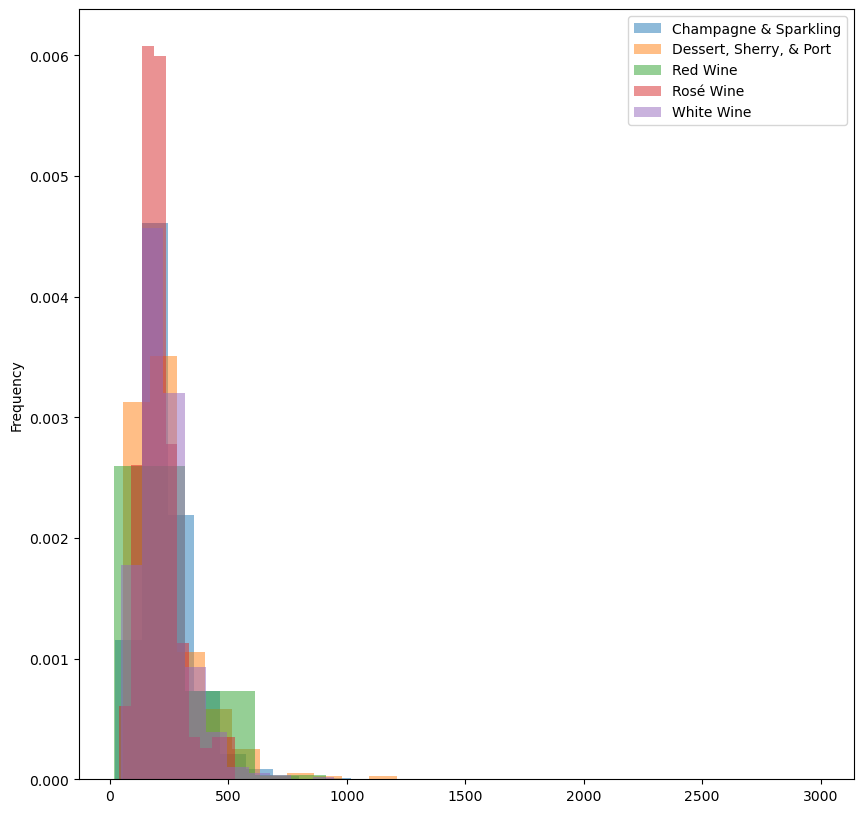

In [26]:
fig = plt.figure(figsize=(10, 10))
review_df.groupby('product_family')['review_length'].plot(kind="hist", 
                                                        density=True, 
                                                        alpha=0.5,
                                                        legend=True)
plt.show()

Interestingly, the distrbution of description and review lengths appear to follow similiar distributions.

### Description Ratings

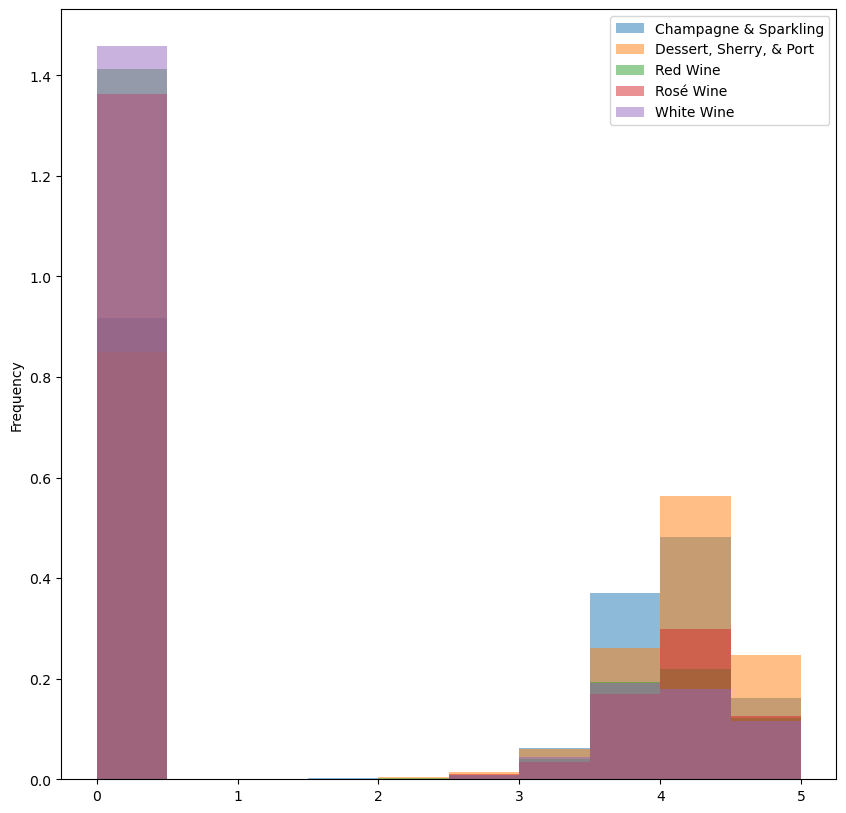

In [30]:
fig = plt.figure(figsize=(10, 10))
description_df.groupby('product_family')['user_avg_rating'].plot(kind="hist", 
                                                                density=True, 
                                                                alpha=0.5,
                                                                legend=True)
plt.show()

Interestingly, the distrbution of user rating indicates that 0.0 is the default value for wines with no user ratings. Depending on the models implemented, this could be import for implementing machine learning models to predict sentiment.

### Review Lengths

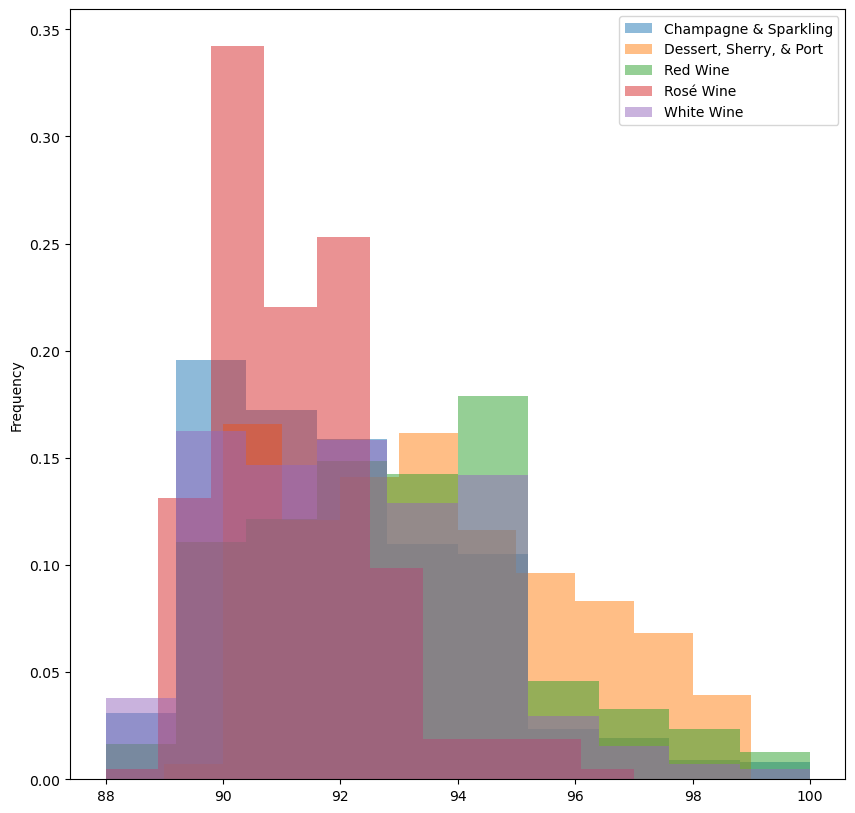

In [31]:
fig = plt.figure(figsize=(10, 10))
review_df.groupby('product_family')['reviewer_rating'].plot(kind="hist", 
                                                            density=True, 
                                                            alpha=0.5,
                                                            legend=True)
plt.show()

### Unique Tokens

Given that there are multiple labels in the set, we will modify a function from prior homework to perform OvR comparisons for terms unique to each wine type.

In [27]:
#modified from homework to be generally useful
def unique_tokens(df, comparison_column, split_column, n_total_corpora, n_top_terms):
    unique_splits = df[split_column].unique()
    for split in unique_splits:
        #perform split
        corpus_1 = df[df[split_column] == split]
        corpus_2 = df[df[split_column] != split]
        #preprocess
        corpus_1_str = corpus_1[comparison_column].astype(str)
        corpus_2_str = corpus_2[comparison_column].astype(str)
        corpus_1_joined = ' '.join(corpus_1_str)
        corpus_2_joined = ' '.join(corpus_2_str)
        corpus_1_tokens = corpus_1_joined.split()
        corpus_2_tokens = corpus_2_joined.split()
        #generate token counts for each corpora
        corpus_1_counts = Counter(corpus_1_tokens)
        corpus_2_counts = Counter(corpus_2_tokens)
        #write to dataframe
        corpus_1_df = pd.DataFrame(data = corpus_1_counts.values(), 
                               index = corpus_1_counts.keys(),
                               columns = ['1_word_counts'])
        corpus_2_df = pd.DataFrame(data = corpus_2_counts.values(), 
                               index = corpus_2_counts.keys(),
                               columns = ['2_word_counts'])
        #join dataframes
        corpus_df = corpus_1_df.merge(corpus_2_df, 
                                      how = 'outer',
                                      left_index = True, 
                                      right_index= True)
        #impute null values with 0
        corpus_df = corpus_df.fillna(0)
        #filtering corpora to required  relevance
        corpus_df = corpus_df[corpus_df['1_word_counts'] >= n_total_corpora]
        corpus_df = corpus_df[corpus_df['2_word_counts'] >= n_total_corpora]
        #calculate term concentrations
        corpus_df['1_concentrations'] = corpus_df['1_word_counts']/len(corpus_1)
        corpus_df['2_concentrations'] = corpus_df['2_word_counts']/len(corpus_2)
        #generate term ratio
        corpus_df['term_ratio'] = corpus_df['1_concentrations']/corpus_df['2_concentrations']
        #sort ratios
        corpus_df = corpus_df.sort_values(by = ['term_ratio'], ascending = False)
        #generate outputs
        corpus_1_top_n = corpus_df['term_ratio'].head(n_top_terms).to_dict()
        #print outputs
        print(f'Unique tokens observed for the label {split}:\n')
        print(corpus_1_top_n)
        print(f'\n')

### Description Unique Terms

In [28]:
unique_tokens(description_df, 
              comparison_column = 'winemaker_description', 
              split_column = 'product_family',
              n_total_corpora = 5,
              n_top_terms = 10)

Unique tokens observed for the label Red Wine:

{'garnet': 62.23942208462333, 'merlot': 48.92604059167527, 'tobacco': 44.511278195488714, 'cabernet': 40.79136147398625, 'sangiovese': 36.80908152734778, 'tannins': 32.652513637033756, 'blueberry': 31.734892787524362, 'cedar': 24.645839196922786, 'zinfandel': 23.005675954592363, 'blackberry': 22.713139585205898}


Unique tokens observed for the label White Wine:

{'riesling': 71.70096702206794, 'grigio': 49.71267046863378, 'lemongrass': 29.078725514505333, 'semillon': 26.290354574758247, 'curd': 25.99160054549963, 'tropical': 23.80277000460487, 'lime': 22.053479250726955, 'guava': 20.71361269526407, 'pineapple': 20.03074634267295, 'gooseberry': 19.41901190181007}


Unique tokens observed for the label Champagne & Sparkling:

{'champagne': 559.9597000937207, 'bubbles': 262.6230985509336, 'mousse': 122.07278975320213, 'sparkling': 74.70298803682672, 'effervescence': 52.62375394052995, 'noirs': 44.3006091846298, 'xarel': 42.1910563663141, 'b

In [29]:
unique_tokens(review_df, 
              comparison_column = 'reviewer_text', 
              split_column = 'product_family',
              n_total_corpora = 5,
              n_top_terms = 10)

Unique tokens observed for the label Red Wine:

{'cabernet': 171.31932873125447, 'purple': 85.42680314210902, 'franc': 78.41245281735641, 'blackberries': 57.549988098071886, 'leather': 47.9028802666032, 'tobacco': 42.447274458462275, 'cassis': 26.359256866279004, 'iron': 25.215543918114736, 'grained': 23.119792906450847, 'garnet': 23.09603155711225}


Unique tokens observed for the label White Wine:

{'riesling': 159.58970358814352, 'roussanne': 25.361154446177846, 'tropical': 24.742589703588145, 'clairette': 20.876560062402497, 'whites': 20.41263650546022, 'honeydew': 19.794071762870516, 'semillon': 18.041471658866357, 'passion': 17.938377535101406, 'adige': 16.701248049921997, 'oily': 13.60842433697348}


Unique tokens observed for the label Champagne & Sparkling:

{'mousse': 149.53577106518281, 'pillowy': 75.68108108108109, 'dough': 42.44932432432432, 'lacy': 39.69287469287469, 'pinpoint': 38.810810810810814, 'vinous': 38.81081081081081, 'aperitif': 38.81081081081081, 'nv': 34.40049

Observing the unique terms produced in the OvR analysis does produce an interesting insight that the reviews tend to focus more on the tasting notes of the product however the types of terms present in these outputs suppports the possiblity that these fields could be combined. Depending on the predictive application, this dynamic could be useful for informing the final model inputs.

## Topic Modeling

In [1]:
#imports
import nltk
#nltk.download('brown')
from nltk.corpus import brown
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [2]:
#directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
processed_folder = parent_directory + '/data/wine-com/processed/'

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LoadData

In [3]:
df = pd.read_csv(processed_folder + '1677432096.083379.txt', sep = '|')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df.head()

,product_url,product_name,product_variety,product_origin,product_family,user_avg_rating,user_rating_count,winemaker_description,reviewer_name,reviewer_rating,reviewer_text
0,https://www.wine.com/product/proyecto-salvaje-...,Proyecto Salvaje del Moncayo Garnacha 2020,Grenache,"from Navarra, Spain",Red Wine,4.8,19,bright burgundy wine medium depth tobacco wild...,Decanter,92.0,part proyecto garnachas de españa collection s...
1,https://www.wine.com/product/proyecto-salvaje-...,Proyecto Salvaje del Moncayo Garnacha 2020,Grenache,"from Navarra, Spain",Red Wine,4.8,19,bright burgundy wine medium depth tobacco wild...,Wilfred Wong of Wine.com,91.0,commentary 2020 proyecto garnachas salvaje del...
2,https://www.wine.com/product/domaine-du-terme-...,Domaine du Terme Gigondas 2019,Rhone Red Blends,"from Gigondas, Rhone, France",Red Wine,4.0,17,NaN,Wine & Spirits,96.0,spectacular gigondas wine red cherry flavors s...
3,https://www.wine.com/product/domaine-du-terme-...,Domaine du Terme Gigondas 2019,Rhone Red Blends,"from Gigondas, Rhone, France",Red Wine,4.0,17,NaN,Decanter,94.0,straight first sniff clear going special soari...
4,https://www.wine.com/product/scott-harvey-moun...,Scott Harvey Mountain Selection Zinfandel 2019,Zinfandel,"from Amador, Sierra Foothills, California",Red Wine,4.3,39,fruit forward rich full flavors expressing var...,Wine Enthusiast,93.0,fresh smelling full bodied flavor packed wine ...


In [4]:
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## what type of wine in the df

In [5]:
# Check if the 'category' column exists in the DataFrame
if 'product_family' in df.columns:
    # Get a list of all unique categories in the DataFrame
    categories = df['product_family'].unique()

    # Loop through each category and print the number of articles in the DataFrame for that category
    for category in categories:
        num_reviews = len(df[df['product_family'] == category])
        print(f"For {category} we have {num_reviews} reviews.")
else:
    print("The 'product_family' column does not exist in the DataFrame.")

For Red Wine we have 12603 reviews.
For White Wine we have 5128 reviews.
For Champagne & Sparkling we have 1961 reviews.
For Rosé Wine we have 479 reviews.
For Dessert, Sherry, & Port we have 817 reviews.


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In the datafram there is 5 types of wine: red, white, champagne, rose, and dessert. the red wine has 12603 reviews, white with 5128 reviews, champange woth 1961 reviews, rose with 479 reviews and dessert with 817 reviews

## what review topics of wine in the df

In [6]:
# Check if the 'reviews' column exists in the DataFrame
if 'reviewer_text' in df.columns:
    # Count the number of non-null values in the 'reviews' column
    num_reviews = df['reviewer_text'].count()

    # Print the total number of reviews in the DataFrame
    print(f"There are {num_reviews} records in the DataFrame.")
else:
    print("The 'reviews' column does not exist in the DataFrame.")

There are 14494 records in the DataFrame.


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


in our data frame there is 14494 reviews

## The shpae of the df

In [7]:
# Define the wine types to search for
wine_types = df['product_family'].unique()

# Define empty lists to hold the category, id, text, and review data for each wine type
category_list = []
id_list = []
text_list = []
review_list = []

# Loop through each wine type
for wine_type in wine_types:
    # Filter the DataFrame to select only the rows that match the wine type
    filtered_df = df[df['product_family'].str.contains(wine_type, case=False)]

    # Loop through each row in the filtered DataFrame
    for index, row in filtered_df.iterrows():
        # Add the category, id, text, and review data to their respective lists
        category_list.append(wine_type)
        id_list.append(row['product_name'])
        text_list.append(row['winemaker_description'])
        review_list.append(row['reviewer_text'])

# Create a new DataFrame from the category, id, text, and review lists
wine_df = pd.DataFrame({
    'category': category_list,
    'id': id_list,
    'text': text_list,
    'reviews': review_list
})

# Print the shape of the new DataFrame
print(wine_df.shape)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(20988, 4)


In [8]:
wine_df.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,category,id,text,reviews
0,Red Wine,Proyecto Salvaje del Moncayo Garnacha 2020,bright burgundy wine medium depth tobacco wild...,part proyecto garnachas de españa collection s...
1,Red Wine,Proyecto Salvaje del Moncayo Garnacha 2020,bright burgundy wine medium depth tobacco wild...,commentary 2020 proyecto garnachas salvaje del...
2,Red Wine,Domaine du Terme Gigondas 2019,NaN,spectacular gigondas wine red cherry flavors s...
3,Red Wine,Domaine du Terme Gigondas 2019,NaN,straight first sniff clear going special soari...
4,Red Wine,Scott Harvey Mountain Selection Zinfandel 2019,fruit forward rich full flavors expressing var...,fresh smelling full bodied flavor packed wine ...


## Review 

In [9]:
wine_df['reviews'] = wine_df['reviews'].fillna('')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Creating the CountVectorizer and TfidVectorizer

In [10]:
#Using the CountVectorizer with the stopwords
count_reviews_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
#Applying the CountVectorizer to the wine_df reviews column 
count_reviews_vectors = count_reviews_vectorizer.fit_transform(wine_df["reviews"])
count_reviews_vectors.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(20988, 5575)

In [11]:
#Using the TfidfVectorizer with the stopwords
tfidf_reviews_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
#Applying the TfidfVectorizer to the wine_df reviews column 
tfidf_reviews_vectors = tfidf_reviews_vectorizer.fit_transform(wine_df["reviews"])
tfidf_reviews_vectors.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(20988, 5575)

## Fitting a Non-Negative Matrix Factorization Model

In [12]:
nmf_reviews_model = NMF(n_components=5, random_state=314)
W_reviews_matrix = nmf_reviews_model.fit_transform(tfidf_reviews_vectors)
H_reviews_matrix = nmf_reviews_model.components_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
display_topics(nmf_reviews_model, tfidf_reviews_vectorizer.get_feature_names())


Topic 00
  medium (3.35)
  tannins (2.76)
  bodied (2.66)
  body (1.92)
  drink (1.67)

Topic 01
  commentary (2.97)
  tasting (2.93)
  san (2.92)
  francisco (2.90)
  tasted (2.86)

Topic 02
  cabernet (2.03)
  sauvignon (1.27)
  merlot (0.90)
  wine (0.84)
  franc (0.83)

Topic 03
  white (1.33)
  lemon (1.20)
  acidity (1.03)
  fresh (1.02)
  apple (0.93)

Topic 04
  cherry (1.90)
  red (1.55)
  black (1.50)
  flavors (1.35)
  fruit (1.12)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


top 5 topics and their top 5 associated words

## Fitting an LSA Model

In [29]:
#creating the SVD model
from sklearn.decomposition import TruncatedSVD
svd_reviews_model = TruncatedSVD(n_components = 10, random_state=42)

In [30]:
#creating the matrix 
W_svd_reviews_matrix = svd_reviews_model.fit_transform(tfidf_reviews_vectors)
H_svd_reviews_matrix = svd_reviews_model.components_

In [31]:
#saving the matrix of the new topic 
wine_df["svd_topic_reviews"] = np.argmax(W_svd_reviews_matrix, axis = 1).astype(str)

In [32]:
#for loop that count the unique topic 
for label in wine_df['svd_topic_reviews'].unique():
    print(f"topic {label} observes original label counts of:")
    print(wine_df[wine_df['svd_topic_reviews'] == label]['category'].value_counts())
    print()

topic 0 observes original label counts of:
Red Wine                   11040
White Wine                  4696
Champagne & Sparkling       1481
Dessert, Sherry, & Port      765
Rosé Wine                    419
Name: category, dtype: int64

topic 1 observes original label counts of:
Red Wine                   482
White Wine                 242
Champagne & Sparkling      172
Rosé Wine                   55
Dessert, Sherry, & Port     25
Name: category, dtype: int64

topic 4 observes original label counts of:
Red Wine                   248
Dessert, Sherry, & Port     12
Champagne & Sparkling        4
White Wine                   3
Rosé Wine                    2
Name: category, dtype: int64

topic 2 observes original label counts of:
Red Wine                   392
Dessert, Sherry, & Port      4
White Wine                   1
Name: category, dtype: int64

topic 8 observes original label counts of:
Red Wine                 23
Champagne & Sparkling     3
Rosé Wine                 3
Name: categor

LSA model showed that topic 0 and 1 have the most relevants to the different wine types. LSA created 10 topics in toll.

## Fitting an LDA Model

In [27]:
# Fit your LDA model here
from sklearn.decomposition import LatentDirichletAllocation
lda_reviews_model = LatentDirichletAllocation(n_components = 10, random_state=42)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
#creating the matrix 
W_lda_reviews_matrix = lda_reviews_model.fit_transform(count_reviews_vectors)
H_lda_reviews_matrix = lda_reviews_model.components_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
#saving the matrix of the new topic 
wine_df["lda_topic_reviews"] = np.argmax(W_lda_reviews_matrix, axis = 1).astype(str)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
#for loop that count the unique topic 
for label in wine_df['lda_topic_reviews'].unique():
    print(f"topic {label} observes original label counts of:")
    print(wine_df[wine_df['lda_topic_reviews'] == label]['category'].value_counts())
    print()

topic 6 observes original label counts of:
Red Wine                   1303
White Wine                  320
Dessert, Sherry, & Port     176
Champagne & Sparkling        70
Rosé Wine                    16
Name: category, dtype: int64

topic 2 observes original label counts of:
Red Wine                   485
White Wine                 244
Champagne & Sparkling      174
Rosé Wine                   55
Dessert, Sherry, & Port     28
Name: category, dtype: int64

topic 0 observes original label counts of:
Red Wine                   5166
White Wine                 2299
Champagne & Sparkling       420
Rosé Wine                   258
Dessert, Sherry, & Port     205
Name: category, dtype: int64

topic 3 observes original label counts of:
Red Wine                   2272
Dessert, Sherry, & Port      63
Champagne & Sparkling        39
Rosé Wine                    26
White Wine                   26
Name: category, dtype: int64

topic 8 observes original label counts of:
Red Wine                   822

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


THe LDA model has then topics topic 0, 1, 4 have the highest observation for all five wine categories. topic 0 is able capture the overall characteristics of the different wine, but topic 1 if able to differentiate from red and white wines. last topic 4 can be used to identifying champagne from the different types of wine 

In [31]:
lda_display_review = pyLDAvis.sklearn.prepare(lda_reviews_model, count_reviews_vectors, count_reviews_vectorizer, sort_topics=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
pyLDAvis.display(lda_display_review)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Hyperparameter tuning 

### Fitting an LSA Model

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)),
    ('svd', TruncatedSVD(random_state=42))
])

# Define the hyperparameter grid
param_grid = {
    'svd__n_components': [5, 10, 15],
    'svd__algorithm': ['randomized', 'arpack', 'full'],
    'svd__tol': [0.0001, 0.001, 0.01]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(wine_df["reviews"])

# Print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
T

Best parameters:  {'svd__algorithm': 'randomized', 'svd__n_components': 5, 'svd__tol': 0.0001}


using the gridSearchCV it gave the the best parameters to be n_componets to be 10, algorithm='randomized', tol=0.001

In [15]:
hyp_svd_reviews_model = TruncatedSVD(n_components=10, random_state=42, algorithm='randomized', tol=0.001)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
#creating the matrix 
W_h_svd_reviews_matrix = hyp_svd_reviews_model.fit_transform(tfidf_reviews_vectors)
H_h_svd_reviews_matrix = hyp_svd_reviews_model.components_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
wine_df["svd_topic_reviews_H"] = np.argmax(W_h_svd_reviews_matrix, axis = 1).astype(str)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
#for loop that count the unique topic 
for label in wine_df['svd_topic_reviews_H'].unique():
    print(f"topic {label} observes original label counts of:")
    print(wine_df[wine_df['svd_topic_reviews_H'] == label]['category'].value_counts())
    print()

topic 0 observes original label counts of:
Red Wine                   11040
White Wine                  4696
Champagne & Sparkling       1481
Dessert, Sherry, & Port      765
Rosé Wine                    419
Name: category, dtype: int64

topic 1 observes original label counts of:
Red Wine                   482
White Wine                 242
Champagne & Sparkling      172
Rosé Wine                   55
Dessert, Sherry, & Port     25
Name: category, dtype: int64

topic 4 observes original label counts of:
Red Wine                   248
Dessert, Sherry, & Port     12
Champagne & Sparkling        4
White Wine                   3
Rosé Wine                    2
Name: category, dtype: int64

topic 2 observes original label counts of:
Red Wine                   392
Dessert, Sherry, & Port      4
White Wine                   1
Name: category, dtype: int64

topic 8 observes original label counts of:
Red Wine                 23
Champagne & Sparkling     3
Rosé Wine                 3
Name: categor

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic 0 and 1 are still the best topics for differentiating the wine types after hyperrameter tuning the LSA

## Fitting an LDA Model

In [19]:
from sklearn.metrics import make_scorer
import numpy as np

# Define a custom scorer based on the log-likelihood metric for LDA
def log_likelihood_scorer(model, X):
    return np.sum(model.score(X))

# Create the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('lda', LatentDirichletAllocation())
])

# Define the hyperparameter grid
param_grid = {
    'vectorizer__max_df': [0.5, 0.75],
    'vectorizer__min_df': [1, 2],
    'lda__n_components': [5, 10],
    'lda__learning_method': ['batch', 'online']
}

# Perform grid search with the custom scorer
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=make_scorer(log_likelihood_scorer), refit=True)
grid_search.fit(wine_df["reviews"])

# Print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters:  {'lda__learning_method': 'batch', 'lda__n_components': 5, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 1}


using the gridSearchCV it gave the the best parameters to be n_componets to be 5, learning_method='batch'

In [20]:
lda_reviews_model_H = LatentDirichletAllocation(learning_method='batch', n_components = 5, random_state=42,)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
#creating the matrix 
W_lda_H_reviews_matrix = lda_reviews_model_H.fit_transform(count_reviews_vectors)
H_lda_H_reviews_matrix = lda_reviews_model_H.components_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
#saving the matrix of the new topic 
wine_df["lda_topic_reviews_H"] = np.argmax(W_lda_H_reviews_matrix, axis = 1).astype(str)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
#for loop that count the unique topic 
for label in wine_df['lda_topic_reviews_H'].unique():
    print(f"topic {label} observes original label counts of:")
    print(wine_df[wine_df['lda_topic_reviews_H'] == label]['category'].value_counts())
    print()

topic 0 observes original label counts of:
Red Wine                   6029
White Wine                 2535
Champagne & Sparkling       435
Rosé Wine                   253
Dessert, Sherry, & Port     249
Name: category, dtype: int64

topic 2 observes original label counts of:
Red Wine                   568
White Wine                 268
Champagne & Sparkling      175
Rosé Wine                   55
Dessert, Sherry, & Port     26
Name: category, dtype: int64

topic 1 observes original label counts of:
Red Wine                   1951
White Wine                 1645
Champagne & Sparkling       615
Dessert, Sherry, & Port     281
Rosé Wine                   110
Name: category, dtype: int64

topic 3 observes original label counts of:
Red Wine                   3761
Dessert, Sherry, & Port      63
White Wine                   10
Rosé Wine                     9
Champagne & Sparkling         6
Name: category, dtype: int64

topic 4 observes original label counts of:
Champagne & Sparkling      730

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


It looks like the tuned LDA redused th eobservation in each topic beside in topic 0, most of the topics are dominated by the red wine hyper tuning didn't make a big difference

In [24]:
lda_display_review_H = pyLDAvis.sklearn.prepare(lda_reviews_model_H, count_reviews_vectors, count_reviews_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display_review_H)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Description 

In [33]:
wine_df['text'] = wine_df['text'].fillna('')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
#Using the CountVectorizer with the stopwords
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
#Applying the CountVectorizer to the wine_df reviews column 
count_text_vectors = count_text_vectorizer.fit_transform(wine_df["text"])
count_text_vectors.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(20988, 7626)

In [35]:
#Using the TfidfVectorizer with the stopwords
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
#Applying the TfidfVectorizer to the wine_df reviews column 
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(wine_df["text"])
tfidf_text_vectors.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(20988, 7626)

## Fitting a Non-Negative Matrix Factorization Model

In [36]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  red (3.38)
  intense (1.71)
  ruby (1.69)
  color (1.43)
  nose (1.19)

Topic 01
  cabernet (9.04)
  merlot (5.63)
  sauvignon (5.27)
  blend (4.59)
  franc (4.33)

Topic 02
  white (1.45)
  fresh (1.32)
  citrus (1.23)
  yellow (1.05)
  notes (0.92)

Topic 03
  black (2.20)
  cherry (1.68)
  dark (1.66)
  flavors (1.15)
  plum (1.12)

Topic 04
  pinot (1.31)
  wine (1.21)
  noir (1.02)
  chardonnay (0.62)
  blend (0.61)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


top 5 topics and their top 5 associated words

## Fitting an LSA Model

In [38]:
svd_text_model = TruncatedSVD(n_components = 10, random_state=42)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
wine_df["svd_topic_text"] = np.argmax(W_svd_text_matrix, axis = 1).astype(str)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
#for loop that count the unique topic 
for label in wine_df['svd_topic_text'].unique():
    print(f"topic {label} observes original label counts of:")
    print(wine_df[wine_df['svd_topic_text'] == label]['category'].value_counts())
    print()

topic 0 observes original label counts of:
Red Wine                   9594
White Wine                 3620
Champagne & Sparkling      1277
Dessert, Sherry, & Port     664
Rosé Wine                   358
Name: category, dtype: int64

topic 4 observes original label counts of:
Red Wine                   1056
White Wine                  563
Champagne & Sparkling       260
Dessert, Sherry, & Port     116
Rosé Wine                    26
Name: category, dtype: int64

topic 6 observes original label counts of:
Red Wine                   102
White Wine                  85
Rosé Wine                   14
Champagne & Sparkling        7
Dessert, Sherry, & Port      3
Name: category, dtype: int64

topic 1 observes original label counts of:
Red Wine                   1138
White Wine                   12
Dessert, Sherry, & Port       6
Rosé Wine                     5
Champagne & Sparkling         2
Name: category, dtype: int64

topic 3 observes original label counts of:
Red Wine                   88


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The LSA model shows bias towards red wine when using description data with topic 0 having the highest cpunt for red wine

## Fitting an LDA Model

In [44]:
lda_text_model = LatentDirichletAllocation(n_components = 10, random_state=42)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
#creating the matrix 
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
#saving the matrix of the new topic 
wine_df["lda_topic"] = np.argmax(W_lda_text_matrix, axis = 1).astype(str)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
#for loop that count the unique topic 
for label in wine_df['lda_topic'].unique():
    print(f"topic {label} observes original label counts of:")
    print(wine_df[wine_df['lda_topic'] == label]['category'].value_counts())
    print()

topic 9 observes original label counts of:
Red Wine                   740
Champagne & Sparkling      275
White Wine                  67
Rosé Wine                   21
Dessert, Sherry, & Port      7
Name: category, dtype: int64

topic 0 observes original label counts of:
White Wine                 2195
Red Wine                   1411
Champagne & Sparkling       682
Dessert, Sherry, & Port     206
Rosé Wine                   135
Name: category, dtype: int64

topic 6 observes original label counts of:
Red Wine                   4642
Dessert, Sherry, & Port      77
Rosé Wine                    18
White Wine                   18
Champagne & Sparkling         9
Name: category, dtype: int64

topic 5 observes original label counts of:
Red Wine                   2910
Dessert, Sherry, & Port      53
White Wine                   27
Champagne & Sparkling        22
Rosé Wine                     9
Name: category, dtype: int64

topic 8 observes original label counts of:
White Wine                 919

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic 0 has th best descrioption for the wine types it has the close observation count to the original were topic 6 and 5 are specific to wine types. 6 focuses on red wines and topic 5 is focused on white and champagne

In [48]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
pyLDAvis.display(lda_display)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
# Display both visualizations
pyLDAvis.display(lda_display)
pyLDAvis.display(lda_display_review)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
